In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We investigate the ATP dataset accessible at https://www.kaggle.com/m3financial/atp-tennis-data-from-201201-to-201707

### The dataset contains information about all pro tour matches compiled with multiple features from Jan. 2012 to Jul. 2017

In [2]:
df_main = pd.read_csv('ATP Dataset_2012-01 to 2017-07_Int_V4.csv')
df_main.columns

Index(['ATP', 'Tournament', 'Tournament_Int', 'Date', 'Series', 'Series_Int',
       'Court', 'Court_Int', 'Surface', 'Surface_Int', 'Round', 'Round_Int',
       'Best_of', 'Winner', 'Winner_Int', 'Player1', 'Player1_Int', 'Player2',
       'Player2_Int', 'Player1_Rank', 'Player2_Rank', 'Player1_Odds',
       'Player2_Odds', 'Player1_Implied_Prob', 'Player2_Implied_Prob'],
      dtype='object')

In [3]:
# Series, Court, Surface, and Round are categorical. 

from pandas.api.types import CategoricalDtype

# We drop matches of Masters and MastersCup. 
# These kind of tournaments have special acceptance criteria which do not allow a direct comparison with regular tournaments 
cat_type_Series = CategoricalDtype(categories=["GrandSlam", "Masters1000", "ATP500", "ATP250"], ordered=True)
df_main['Series'] = df_main['Series'].astype(cat_type_Series)

cat_type_Court = CategoricalDtype(categories=["Indoor", "Outdoor"], ordered=True)
df_main['Court'] = df_main['Court'].astype(cat_type_Court)

cat_type_Surface = CategoricalDtype(categories=["Hard", "Grass", "Clay"], ordered=True)
df_main['Surface'] = df_main['Surface'].astype(cat_type_Surface)

cat_type_Round = CategoricalDtype(categories=["TheFinal", "Semifinals", "Quarterfinals", "4thRound", "3rdRound", "2ndRound", "1stRound"], ordered=True)
df_main['Round'] = df_main['Round'].astype(cat_type_Round)

df_main = df_main.dropna(axis=0, how='any')



# In the first part we aim to understand how difficult is to predict the outcome of a tennis match.

The favourite for a match is given by the player with lower Odds (and consequently a higher Implied_Probability = 1/Odds). 

We aim to understand when the forecasts more often come true.

As a first step, we need to wrangle the dataset. In this first part we won't use specific information relative to Date, Players', and Tournaments' Id

In [4]:
# Select a subset of the dataframe

df = df_main[['Series', 'Court', 'Surface', 'Round', 
       'Winner', 'Player1', 'Player2',
       'Player1_Rank', 'Player2_Rank', 'Player1_Odds',
       'Player2_Odds', 'Player1_Implied_Prob', 'Player2_Implied_Prob']]

df.head()

,Series,Court,Surface,Round,Winner,Player1,Player2,Player1_Rank,Player2_Rank,Player1_Odds,Player2_Odds,Player1_Implied_Prob,Player2_Implied_Prob
0,ATP250,Outdoor,Hard,1stRound,ThompsonJ.,YmerE.,ThompsonJ.,160.0,79.0,3.50,1.29,0.2857,0.7752
1,ATP250,Outdoor,Hard,1stRound,MahutN.,MahutN.,RobertS.,39.0,54.0,1.54,2.43,0.6494,0.4115
2,ATP250,Outdoor,Hard,1stRound,FerrerD.,TomicB.,FerrerD.,26.0,21.0,1.77,2.01,0.5650,0.4975
3,ATP250,Outdoor,Hard,1stRound,EdmundK.,EdmundK.,EscobedoE.,45.0,141.0,1.37,3.01,0.7299,0.3322
4,ATP250,Outdoor,Hard,1stRound,DimitrovG.,JohnsonS.,DimitrovG.,33.0,17.0,2.85,1.41,0.3509,0.7092


/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


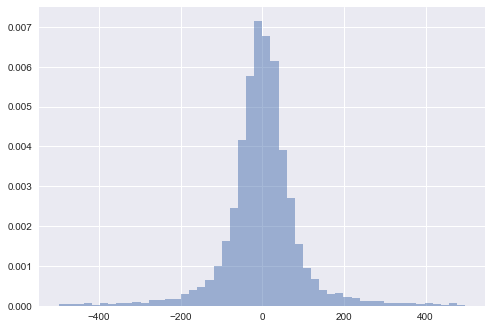

In [5]:
# We do not consider too extreme condition, i.e., we restrict the ranking difference between players to 500.
# Note that in the Grand Slams (the largest tournments) only the 128 players compete.

df['Ranking_Diff'] = df['Player1_Rank'] - df['Player2_Rank']
df = df[ (df['Ranking_Diff'] < 500) & (df['Ranking_Diff'] > -500) ].reset_index()

num_bins = 50

plt.hist(df['Ranking_Diff'], bins=num_bins, normed = True, alpha = 0.5 )

plt.show()

In [6]:
# Create an auxiliary column: 0/1 depending on whether Player1 won

df['Is_Winner_Player_1'] = [df.loc[ind, 'Winner'] == df.loc[ind, 'Player1'] for ind in df.index ] 
df['Is_Favourite_Player_1'] = [df.loc[ind, 'Player1_Implied_Prob'] > df.loc[ind, 'Player2_Implied_Prob'] for ind in df.index ] 

# Identify whether a match has an unexpected outcome: the winner is not the favourite
df['Underdog'] = df['Underdog'] = df['Is_Winner_Player_1'] ^ df['Is_Favourite_Player_1']

# Implied_Probbaility and Odds of the winner and of the favourite
df['Winner_Implied_Prob'] = df['Is_Winner_Player_1']*df['Player1_Implied_Prob'] + (1 - df['Is_Winner_Player_1'])*df['Player2_Implied_Prob']
df['Winner_Odds'] = df['Is_Winner_Player_1']*df['Player1_Odds'] + (1 - df['Is_Winner_Player_1'])*df['Player2_Odds']
df['Fav_Odds'] = df['Is_Favourite_Player_1']*df['Player1_Odds'] + (1 - df['Is_Favourite_Player_1'])*df['Player2_Odds']
df['Fav_Implied_Prob'] = df['Is_Favourite_Player_1']*df['Player1_Implied_Prob'] + (1 - df['Is_Favourite_Player_1'])*df['Player2_Implied_Prob']

# Difference in ranking between Underdog and Favourite : the higher the difference, the more likely should be to have
# a low odd for the favourite (high Implied_Probability). We will investigate this correlation.
df['Diff_Ranking_Und_Fav'] = - df['Ranking_Diff'] * df['Is_Favourite_Player_1'] \
                             + df['Ranking_Diff'] * (1 - df['Is_Favourite_Player_1'])


# We remove the columns we will not not use
del df['index']
del df['Is_Winner_Player_1'] 
del df['Is_Favourite_Player_1']
del df['Winner']
del df['Player1']
del df['Player2']
del df['Player1_Rank']
del df['Player2_Rank'] 
del df['Player1_Odds']
del df['Player2_Odds'] 
del df['Player1_Implied_Prob']
del df['Player2_Implied_Prob'] 
del df['Ranking_Diff']

df.head()

,Series,Court,Surface,Round,Underdog,Winner_Implied_Prob,Winner_Odds,Fav_Odds,Fav_Implied_Prob,Diff_Ranking_Und_Fav
0,ATP250,Outdoor,Hard,1stRound,False,0.7752,1.29,1.29,0.7752,81.0
1,ATP250,Outdoor,Hard,1stRound,False,0.6494,1.54,1.54,0.6494,15.0
2,ATP250,Outdoor,Hard,1stRound,True,0.4975,2.01,1.77,0.5650,-5.0
3,ATP250,Outdoor,Hard,1stRound,False,0.7299,1.37,1.37,0.7299,96.0
4,ATP250,Outdoor,Hard,1stRound,False,0.7092,1.41,1.41,0.7092,16.0


# Roughly 30% of matches have an unexpected outcome

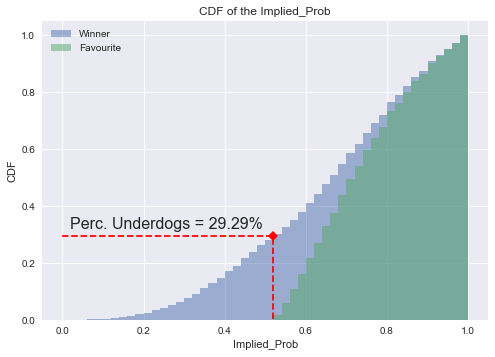

In [7]:
num_bins = 50

plt.hist(df['Winner_Implied_Prob'], bins=num_bins, range = (0,1), normed = True, cumulative=True, alpha = 0.5, label='Winner' )
plt.hist(df['Fav_Implied_Prob'], bins=num_bins, range = (0,1), normed = True, cumulative=True, alpha = 0.5, label='Favourite'  )

frac_underdogs = np.mean(df['Underdog'])

plt.plot([0,0.52,0.52],[frac_underdogs, frac_underdogs,0], linestyle = '--', color = 'red')
plt.plot([0.52],[frac_underdogs], linestyle = '--', color = 'red', marker = 'D')

plt.text(0.02, 0.32, 'Perc. Underdogs = ' + str( int(np.mean(df['Underdog'])*10000)/100 ) + '%', fontsize=16)

plt.legend()
plt.title('CDF of the Implied_Prob')
plt.xlabel('Implied_Prob')
plt.ylabel('CDF')
plt.show()

## (1) The fraction of unexpected outcomes is surprisingly large when a game is played on clay and indoor. In general, matches on indoor courts seem slightly more difficult to predict. 

That is probably due to the low amount of observations (only 162 matches), note that when we aggregate indoor and outdoor the anomaly disappears, i.e., the fraction of unexpected outcomes on Clay is roughly 30%.  


On clay indoor there have been 63 unexpected outcomes out of 162 matches: 38.88% of the total


/home/fabio/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


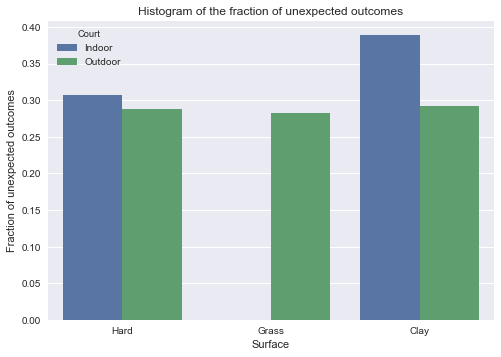

/home/fabio/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


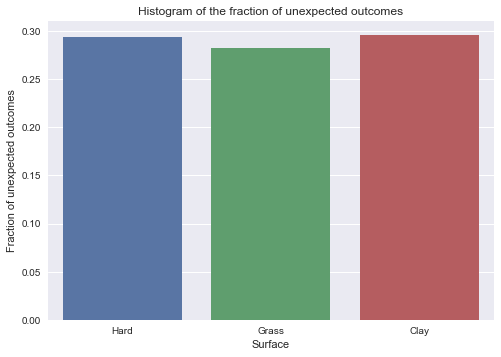

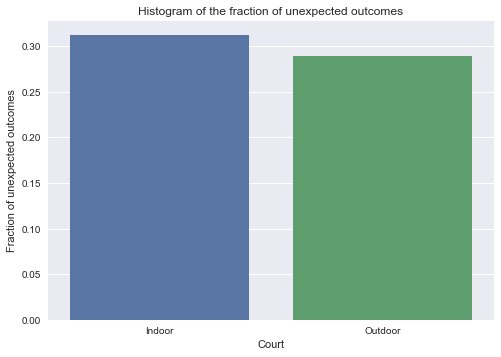

In [8]:
df_clay_out = df[(df['Surface']=='Clay') & (df['Court']=='Indoor')]
clay_out_tot = df_clay_out.shape[0] 
clay_out_und = sum(df_clay_out['Underdog'])

print('On clay indoor there have been ' + str(clay_out_und) + ' unexpected outcomes out of ' + str(clay_out_tot) + ' matches: ' + str( int((clay_out_und/clay_out_tot)*10000)/100 ) + '% of the total')  


# Group by Surface and Court
sns.barplot(x = 'Surface', y = 'Underdog', hue = 'Court', data = df, ci = None)

plt.title('Histogram of the fraction of unexpected outcomes')
plt.xlabel('Surface')
plt.ylabel('Fraction of unexpected outcomes')
plt.show()


# Group by Surface 
sns.barplot(x = 'Surface', y = 'Underdog', data = df, ci = None)

plt.title('Histogram of the fraction of unexpected outcomes')
plt.xlabel('Surface')
plt.ylabel('Fraction of unexpected outcomes')
plt.show()


# Group by Court 
sns.barplot(x = 'Court', y = 'Underdog', data = df, ci = None)

plt.title('Histogram of the fraction of unexpected outcomes')
plt.xlabel('Court')
plt.ylabel('Fraction of unexpected outcomes')
plt.show()



## (2) The fraction of unexpected events gets lower as the importance of the tournment increases.

As the tournament importance increases, the favourites appear more focused and less inclined to be surprised by less favourite players.


In GrandSlams there have been 643 unexpected outcomes out of 2886 matches: 22.27% of the total
In ATP250 there have been 1958 unexpected outcomes out of 6079 matches: 32.2% of the total


/home/fabio/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


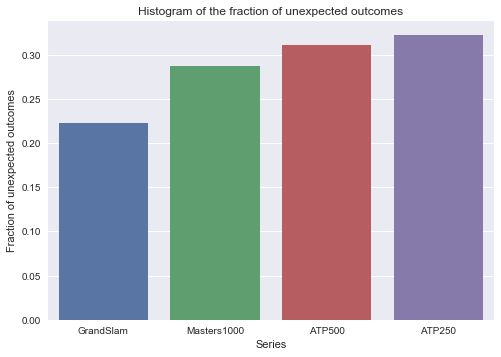

In [9]:
df_GS = df[(df['Series']=='GrandSlam')]
GS_tot = df_GS.shape[0] 
GS_und = sum(df_GS['Underdog'])

df_250 = df[(df['Series']=='ATP250')]
tot_250 = df_250.shape[0] 
und_250 = sum(df_250['Underdog'])

print('In GrandSlams there have been ' + str(GS_und) + ' unexpected outcomes out of ' + str(GS_tot) + ' matches: ' + str( int((GS_und/GS_tot)*10000)/100 ) + '% of the total')  

print('In ATP250 there have been ' + str(und_250) + ' unexpected outcomes out of ' + str(tot_250) + ' matches: ' + str( int((und_250/tot_250)*10000)/100 ) + '% of the total')  



sns.barplot(x = 'Series', y = 'Underdog', data = df, ci = None)

plt.title('Histogram of the fraction of unexpected outcomes')
plt.xlabel('Series')
plt.ylabel('Fraction of unexpected outcomes')

plt.show()



## (3) The fraction of unexpected events is higher at the beginning and the end of a tournament. 

In the first round, intuitively, it is more difficult to forecast the condition of a player and that fosters unexpected outcomes. After the first matches, the condition of the players becomes clearer.    

On the other hand, as the tournament approaches the last rounds, the level of the players balances and the matches' outcome is more uncertain, both outcomes approaches a 0.5 probability. This is further explored in (4).


/home/fabio/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


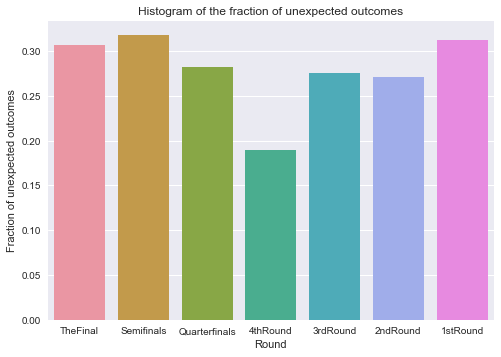

In [10]:
sns.barplot(x = 'Round', y = 'Underdog', data = df, ci = None)

plt.title('Histogram of the fraction of unexpected outcomes')
plt.xlabel('Round')
plt.ylabel('Fraction of unexpected outcomes')

plt.show()



## (4) The probability of winning/losing become more uniform as the tournament approaches the last rounds. 

As the tournament approaches the last rounds, the level of the players balances and the matches' outcome is more uncertain. We observe that most of the extreme outcomes happen in the first rounds. 

In the time frame considered only one observation among finals and semifinals with Odds above 10 (Implied_Prob 0.1).


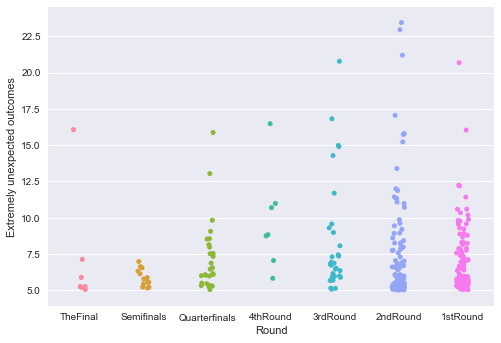

In [11]:
# We consider only the more extreme outcomes in which the winner had an odd above 5, 
# i.e., a probability of winning lower than 0.2, and show the relative observations.

df_extr = df[df['Winner_Odds'] > 5]

sns.stripplot(x = 'Round', y = 'Winner_Odds', data = df_extr, jitter = True, size = 5)

plt.ylabel('Extremely unexpected outcomes')

plt.show()



## (5) The higher the difference in ranking, the higher the Implied_Prob of the favourite

As expected the difference in ranking (Rank of the Favourite - Rank of the Underdog) is positively correlated with the probability of the favourite to win.

/home/fabio/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


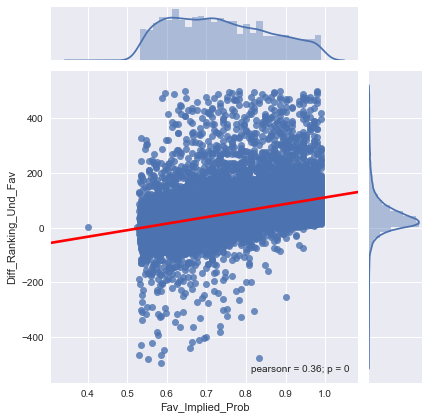

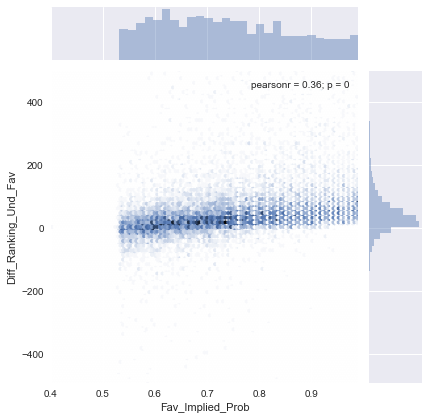

In [12]:
sns.jointplot(x='Fav_Implied_Prob', y='Diff_Ranking_Und_Fav', data = df, kind='reg',joint_kws={'line_kws':{'color':'red'}})

plt.show()

sns.jointplot(x='Fav_Implied_Prob', y='Diff_Ranking_Und_Fav', data = df, kind='hex')

plt.show()

# In the second part we look at the top players, capture the evolution of their ranking over the years and aim to understand on which of them one should always bet.


In [13]:
# The date is in a OLE format and we convert it to the more standard datetime

from datetime import timedelta, datetime

st = datetime(1899,12,31)

aux = [st + timedelta(days=int(df_main.loc[ind, 'Date']))  for ind in df_main.index ] 

df_main['Date'] = aux

df_main.head()

,ATP,Tournament,Tournament_Int,Date,Series,Series_Int,Court,Court_Int,Surface,Surface_Int,...,Player1,Player1_Int,Player2,Player2_Int,Player1_Rank,Player2_Rank,Player1_Odds,Player2_Odds,Player1_Implied_Prob,Player2_Implied_Prob
0,1,BrisbaneInternational,1.2757,2017-01-03,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,YmerE.,6.7633,ThompsonJ.,6.7926,160.0,79.0,3.50,1.29,0.2857,0.7752
1,1,BrisbaneInternational,1.2757,2017-01-03,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,MahutN.,6.9297,RobertS.,6.9686,39.0,54.0,1.54,2.43,0.6494,0.4115
2,1,BrisbaneInternational,1.2757,2017-01-03,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,TomicB.,6.5792,FerrerD.,6.3881,26.0,21.0,1.77,2.01,0.5650,0.4975
3,1,BrisbaneInternational,1.2757,2017-01-03,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,EdmundK.,6.8384,EscobedoE.,6.0929,45.0,141.0,1.37,3.01,0.7299,0.3322
4,1,BrisbaneInternational,1.2757,2017-01-03,ATP250,2.9693,Outdoor,3.6494,Hard,4.4983,...,JohnsonS.,6.7032,DimitrovG.,6.5157,33.0,17.0,2.85,1.41,0.3509,0.7092


In [14]:
# Select the best players, those that in the period of time considered have partecipated in a tournament while being in
# the top 5 of the ATP ranking

df_best_1 = set(df_main[(df_main['Player1_Rank'] <= 4)].Player1)
df_best_2 = set(df_main[(df_main['Player2_Rank'] <= 4)].Player2)

best_players = df_best_1.union(df_best_2)
best_players


{'BerdychT.',
 'DelPotroJ.M.',
 'DjokovicN.',
 'FedererR.',
 'FerrerD.',
 'MurrayA.',
 'NadalR.',
 'NishikoriK.',
 'RaonicM.',
 'WawrinkaS.'}

Observe that only 10 players have been in the top 4 ranking in between Jan. 2012 and Jul. 2017 

In [15]:
df_b = df_main[['Date', 'Player1', 'Player1_Rank', 'Player2', 'Player2_Rank', 'Player1_Odds', 'Player2_Odds', 'Winner']]


# Create an auxiliary column: 0/1 depending on whether Player1 won
df_b['Is_Winner_Player_1'] = [df_b.loc[ind, 'Winner'] == df_b.loc[ind, 'Player1'] for ind in df_b.index ] 
df_b['Is_Winner_Player_2'] = [df_b.loc[ind, 'Winner'] == df_b.loc[ind, 'Player2'] for ind in df_b.index ] 


list_best_players_df = []

for player in best_players:
    
    df_pla1 = df_b.loc[df_b['Player1'] == player,['Date','Player1','Player1_Rank','Player1_Odds','Is_Winner_Player_1']]
    df_pla2 = df_b.loc[df_b['Player2'] == player,['Date','Player2','Player2_Rank','Player2_Odds','Is_Winner_Player_2']]
    df_pla1.columns = ['Date','Player','Player_Rank', 'Odds', 'Win']
    df_pla2.columns = ['Date','Player','Player_Rank', 'Odds', 'Win']
    df_pla = pd.concat([df_pla1, df_pla2])
    
    list_best_players_df = list_best_players_df + [df_pla]
    
df_best_pla = pd.concat(list_best_players_df, ignore_index=True)

df_best_pla = df_best_pla.sort_values('Date').reset_index()

del df_best_pla['index']


df_best_pla.head()

/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Player,Player_Rank,Odds,Win
0,2012-01-04,NadalR.,2.0,1.10,True
1,2012-01-04,MurrayA.,4.0,1.02,True
2,2012-01-04,FedererR.,3.0,1.11,True
3,2012-01-04,NishikoriK.,25.0,1.25,True
4,2012-01-05,NishikoriK.,25.0,2.27,False


### (1) We explore the evolution of the best player rankings in the time window considered

Note that Del Potro suffered a bad injury and was forced to stop playing for a long period. His ranking clearly suffered for this reason. 

In the second plot we excluded him, so as to have a better overview of the evolution of the rankings of the other players.


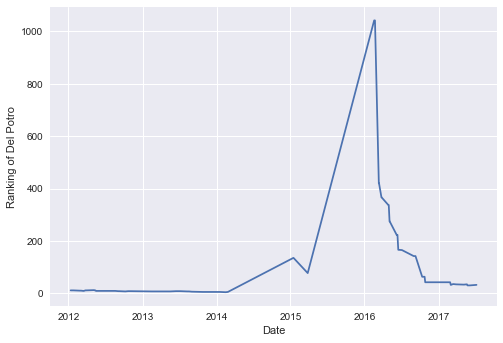

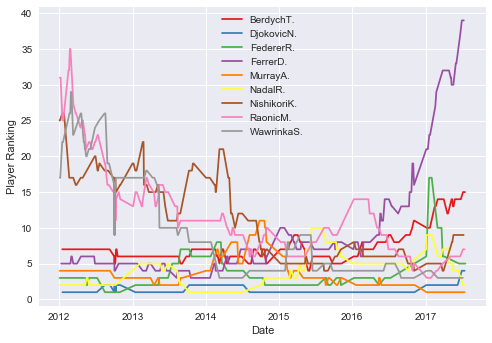

In [16]:
df_DelPo = df_best_pla[df_best_pla['Player'] == 'DelPotroJ.M.']
df_DelPo = df_DelPo.set_index('Date')
    
plt.plot(df_DelPo['Player_Rank'])
    
plt.xlabel('Date')
plt.ylabel('Ranking of Del Potro')    
plt.show()

df_best_pla_noDelPotro = df_best_pla[df_best_pla['Player'] != 'DelPotroJ.M.']

with sns.color_palette("Set1", n_colors=9):

    for player, df_pla in df_best_pla_noDelPotro.groupby(['Player']): 
    
        df_pla = df_pla.set_index('Date')
    
        plt.plot(df_pla['Player_Rank'], label = player)
    
    plt.xlabel('Date')
    plt.ylabel('Player Ranking')    
    plt.legend(loc='best')    
     
    plt.show()



### (2) The plot in (1) is quite messy and of difficult interpretation. We now smoothen the time series.

As we look at the average ranking over the previous year, we can observe the different trends:
- Murray and Djokovic appear solidly at the top of the ranking
- Nishikori, Raonic, and Wawrinka drastically improved their ranking in the window of time considered
- Ferrer and Berdych are losing positions in the last years
- Nadal and Federer seem to suffer as well, there are no observations after Jul.2017 otherwise their trend would have been way different....

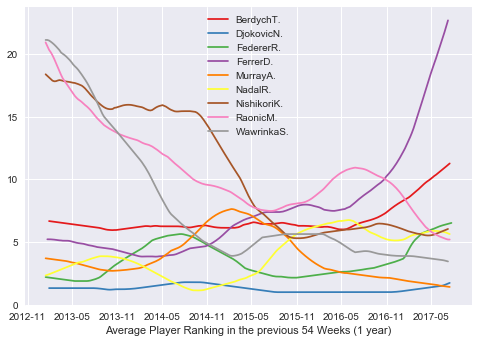

In [17]:
with sns.color_palette("Set1", n_colors=9):

    for player, df_pla in df_best_pla_noDelPotro.groupby(['Player']): 
    
        df_pla = df_pla.set_index('Date')
    
        df_pla = df_pla.resample('W').first()
        df_pla = df_pla.interpolate()
    
        df_pla_roll = df_pla.rolling(window=54).mean()
    
        plt.plot(df_pla_roll['Player_Rank'], label = player)
    
    
    plt.xlabel('Date')
    plt.xlabel('Average Player Ranking in the previous 54 Weeks (1 year)')
    plt.legend(loc='best')    
    plt.show()

### (3) It is better to support a rising star than an already accomplished player.

Imagine to be a very methodical gambler, you support one of the best players and every time he plays (no matter against who) you bet $1 on him. How much would you win in between Jan.2012 and Jul.2017?

Note that if your player win, then you gain USD (Odds - 1), if he loses you lose USD 1. This amount is saved in the column 'Bet_Wins'.

What we observe is that:
- Only if you were a supporter of Wawrinka or Nishikori (rising stars) you won something.
- If you were a supporter of Federer, Murray, Nadal, and Djokovic (accomplished players at Jul.2012) you have either the same amount of money (Federer), or you lost a bit (Murray and Djokovic), or you lost a lot (Nadal).
- Although being a rising star, being a supporter of Raonic did not pay much.
- As expected, supporting Ferrer and Berdych (declining rankings) led to losses.

/home/fabio/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


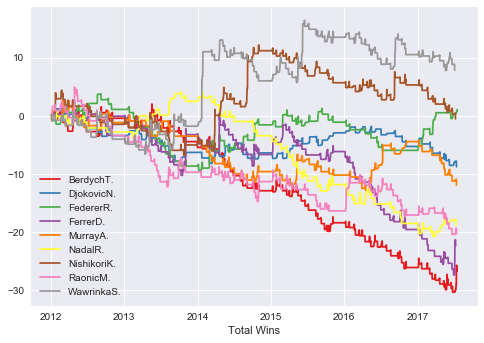

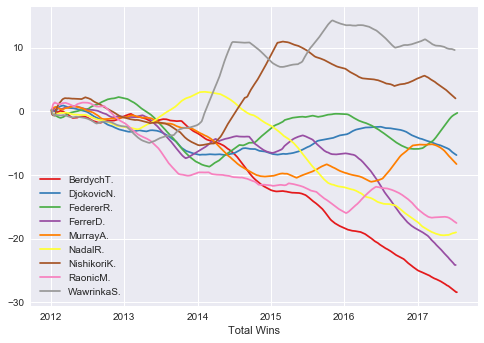

In [18]:
# Create the column 'Bet_Wins'
df_best_pla_noDelPotro['Bet_Wins'] = df_best_pla_noDelPotro['Win']*df_best_pla_noDelPotro['Odds'] - 1

df_best_bet = df_best_pla_noDelPotro[['Date', 'Player', 'Bet_Wins']]

# Plot the amount of win by date:

# 1 - group by player, 
# 2 - resample by day (we assume there are no more than one match per day), 
# 3 - fill the NaN with 0 (an NaN means that the player has not played in that day),
# 4 - rolling method to sum the 'Bet_Wins' over every game so far
# 5 - plot

# In the second plot, we add another step after 4 by smoothening the time-series across the previous 150 days

with sns.color_palette("Set1", n_colors=9):

    for player, df_pla in df_best_bet.groupby(['Player']): 
    
        df_pla = df_pla.set_index('Date')
    
        df_pla = df_pla.resample('D').first()
        df_pla = df_pla.fillna(0)
    
        df_pla_roll = df_pla.rolling(window=df_pla.shape[0], min_periods = 1).sum()
    
        plt.plot(df_pla_roll['Bet_Wins'], label = player)
    
    
    plt.xlabel('Date')
    plt.xlabel('Total Wins')
    plt.legend(loc='best')    
    plt.show()
    
    
    for player, df_pla in df_best_bet.groupby(['Player']): 
    
        df_pla = df_pla.set_index('Date')
    
        df_pla = df_pla.resample('D').first()
        df_pla = df_pla.fillna(0)
    
        df_pla_roll = df_pla.rolling(window=df_pla.shape[0], min_periods = 1).sum()
        df_pla_roll_2 = df_pla_roll.rolling(window=150, min_periods = 1).mean()
    
        plt.plot(df_pla_roll_2['Bet_Wins'], label = player)
    
    
    plt.xlabel('Date')
    plt.xlabel('Total Wins')
    plt.legend(loc='best')    
    plt.show()
    
    